# Analyse Données

## Import des fichiers

In [2]:
#Temps et fichiers
import os
import warnings
import time
from datetime import timedelta

#Manipulation de données
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from functools import partial


#Modélisation
from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import PoissonRegressor, GammaRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import mean_tweedie_deviance
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, auc

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV# the keys can be accessed with final_pipeline.get_params().keys()
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

#Text
import re

#Evaluation
from sklearn.metrics import f1_score, confusion_matrix


#Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


#Tracking d'expérience
import mlflow
import mlflow.sklearn

## Utilisation du code du projet packagé

In [3]:
#Cette cellule permet d'appeler la version packagée du projet et d'en assurer le reload avant appel des fonctions
%load_ext autoreload
%autoreload 2

In [4]:
random_state=42

## Configuration de l'experiment MLFlow

In [5]:
mlflow.tracking.get_tracking_uri()

'/mnt/experiments'

## Chargement des données

In [6]:
df_merged = pd.read_parquet('/mnt/data/interim/df_merged.gzip')

On vire `NBSIN_TYPE1_AN2` => vu avec André : pb dans la variable qui est >=1

In [7]:
df_merged=df_merged.drop('NBSIN_TYPE1_AN2', axis=1)

In [8]:
df_train, df_val = train_test_split(df_merged, shuffle=False, test_size=0.2, random_state=random_state)

In [9]:
X_test=expo_test = pd.read_csv('/mnt/data/raw/expo_test.csv', encoding='utf8', sep=',' )

In [10]:
X_test=X_test.drop(['Unnamed: 0', 'NBSIN_TYPE1_AN2'], axis=1)

In [11]:
X_test

,EXPO,FORMULE,TYPE_RESIDENCE,TYPE_HABITATION,NB_PIECES,SITUATION_JURIDIQUE,NIVEAU_JURIDIQUE,VALEUR_DES_BIENS,OBJETS_DE_VALEUR,ZONIER,NBSIN_TYPE1_AN1,NBSIN_TYPE1_AN3,NBSIN_TYPE2_AN1,NBSIN_TYPE2_AN2,NBSIN_TYPE2_AN3,id,ANNEE
0,1.000000,CONFORT,PRINCIPALE,APPARTEMENT,4.0,LOCATAIRE,JUR1,35000.0,NIVEAU_1,B43,0,0,0,NaN,0,2,2019
1,0.468493,CONFORT,SECONDAIRE,MAISON,1.0,PROPRIO,JUR1,0.0,NIVEAU_1,C22,0,0,0,0.0,0,10,2019
2,0.852055,ESSENTIEL,PRINCIPALE,APPARTEMENT,0.0,PROPRIO,JUR1,0.0,NIVEAU_1,B32,0,0,0,0.0,0,18,2019
3,1.000000,CONFORT,PRINCIPALE,APPARTEMENT,3.0,LOCATAIRE,JUR1,50000.0,NIVEAU_1,C6,0,1,0,0.0,0,19,2019
4,0.079452,CONFORT,SECONDAIRE,MAISON,1.0,PROPRIO,JUR1,9000.0,NIVEAU_1,C6,0,0,0,0.0,0,39,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44344,1.000000,CONFORT,PRINCIPALE,APPARTEMENT,3.0,LOCATAIRE,JUR1,35000.0,NIVEAU_1,C5,0,0,0,0.0,0,499935,2019
44345,0.073973,CONFORT,SECONDAIRE,MAISON,2.0,LOCATAIRE,JUR1,0.0,NIVEAU_1,C6,0,0,0,0.0,0,499953,2019
44346,1.000000,ESSENTIEL,PRINCIPALE,MAISON,2.0,LOCATAIRE,JUR1,20000.0,NIVEAU_1,C13,0,0,0,0.0,0,499964,2019
44347,1.000000,CONFORT,PRINCIPALE,MAISON,2.0,LOCATAIRE,JUR1,9000.0,NIVEAU_1,C17,0,0,0,0.0,0,499969,2019


In [12]:
list(X_test)

['EXPO',
 'FORMULE',
 'TYPE_RESIDENCE',
 'TYPE_HABITATION',
 'NB_PIECES',
 'SITUATION_JURIDIQUE',
 'NIVEAU_JURIDIQUE',
 'VALEUR_DES_BIENS',
 'OBJETS_DE_VALEUR',
 'ZONIER',
 'NBSIN_TYPE1_AN1',
 'NBSIN_TYPE1_AN3',
 'NBSIN_TYPE2_AN1',
 'NBSIN_TYPE2_AN2',
 'NBSIN_TYPE2_AN3',
 'id',
 'ANNEE']

In [13]:
list(df_train)

['EXPO',
 'FORMULE',
 'TYPE_RESIDENCE',
 'TYPE_HABITATION',
 'NB_PIECES',
 'SITUATION_JURIDIQUE',
 'NIVEAU_JURIDIQUE',
 'VALEUR_DES_BIENS',
 'OBJETS_DE_VALEUR',
 'ZONIER',
 'NBSIN_TYPE1_AN1',
 'NBSIN_TYPE1_AN3',
 'NBSIN_TYPE2_AN1',
 'NBSIN_TYPE2_AN2',
 'NBSIN_TYPE2_AN3',
 'id',
 'ANNEE',
 'NB',
 'COUT',
 'PurePremium',
 'Frequency',
 'AvgClaimAmount']

In [14]:
y_train = df_train[['id','EXPO','NB',
 'COUT',
 'PurePremium',
 'Frequency',
 'AvgClaimAmount']]

In [15]:
y_train

,id,EXPO,NB,COUT,PurePremium,Frequency,AvgClaimAmount
0,5,1.000000,0.0,0.0,0.0,0.0,0.0
1,9,0.824657,0.0,0.0,0.0,0.0,0.0
2,11,1.000000,0.0,0.0,0.0,0.0,0.0
3,13,1.000000,0.0,0.0,0.0,0.0,0.0
4,14,1.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
124515,400345,1.000000,0.0,0.0,0.0,0.0,0.0
124516,400348,1.000000,0.0,0.0,0.0,0.0,0.0
124517,400350,0.273973,0.0,0.0,0.0,0.0,0.0
124518,400356,1.000000,0.0,0.0,0.0,0.0,0.0


In [16]:
y_train.describe()

,id,EXPO,NB,COUT,PurePremium,Frequency,AvgClaimAmount
count,124520.000000,124520.000000,124520.000000,124520.000000,124520.000000,124520.000000,124520.000000
mean,200071.902337,0.837586,0.017917,24.986664,32.123230,0.022580,24.359367
std,115728.477177,0.296708,0.136705,376.735988,749.479255,0.281951,369.059132
min,5.000000,0.002732,0.000000,0.000000,0.000000,0.000000,0.000000
25%,99973.500000,0.816438,0.000000,0.000000,0.000000,0.000000,0.000000
50%,200222.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,300233.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,400357.000000,1.000000,3.000000,33089.120000,185244.917127,52.285749,33089.120000


In [17]:
X_train = df_train.drop(['NB',
 'COUT',
 'PurePremium',
 'Frequency',
 'AvgClaimAmount'], axis=1)

In [18]:
X_train

,EXPO,FORMULE,TYPE_RESIDENCE,TYPE_HABITATION,NB_PIECES,SITUATION_JURIDIQUE,NIVEAU_JURIDIQUE,VALEUR_DES_BIENS,OBJETS_DE_VALEUR,ZONIER,NBSIN_TYPE1_AN1,NBSIN_TYPE1_AN3,NBSIN_TYPE2_AN1,NBSIN_TYPE2_AN2,NBSIN_TYPE2_AN3,id,ANNEE
0,1.000000,MEDIUM,PRINCIPALE,APPARTEMENT,1.0,PROPRIO,JUR1,3500.0,NIVEAU_1,B40,0,0,0,0.0,0,5,2017
1,0.824657,CONFORT,PRINCIPALE,MAISON,NaN,PROPRIO,JUR1,0.0,NIVEAU_1,A11,0,0,0,0.0,0,9,2018
2,1.000000,ESSENTIEL,PRINCIPALE,APPARTEMENT,3.0,LOCATAIRE,JUR1,35000.0,NIVEAU_1,B32,0,0,0,0.0,0,11,2017
3,1.000000,ESSENTIEL,SECONDAIRE,MAISON,2.0,LOCATAIRE,JUR1,9000.0,NIVEAU_1,C24,0,0,0,0.0,0,13,2018
4,1.000000,ESSENTIEL,PRINCIPALE,MAISON,1.0,LOCATAIRE,JUR1,20000.0,NIVEAU_1,C9,0,0,0,0.0,0,14,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124515,1.000000,CONFORT,PRINCIPALE,MAISON,1.0,PROPRIO,JUR1,3500.0,NIVEAU_1,C20,1,0,0,0.0,0,400345,2018
124516,1.000000,MEDIUM,PRINCIPALE,MAISON,2.0,PROPRIO,JUR1,3500.0,NIVEAU_1,A2,0,0,0,0.0,0,400348,2017
124517,0.273973,CONFORT,SECONDAIRE,MAISON,1.0,PROPRIO,JUR1,3500.0,NIVEAU_1,C16,0,0,0,0.0,0,400350,2018
124518,1.000000,MEDIUM,PRINCIPALE,MAISON,2.0,LOCATAIRE,JUR1,3500.0,NIVEAU_1,C9,0,0,0,0.0,0,400356,2016


In [19]:
X_val = df_val.drop(['NB',
 'COUT',
 'PurePremium',
 'Frequency',
 'AvgClaimAmount'], axis=1)

In [20]:
y_val = df_val[['id','EXPO','NB',
 'COUT',
 'PurePremium',
 'Frequency',
 'AvgClaimAmount']]

In [21]:
y_val

,id,EXPO,NB,COUT,PurePremium,Frequency,AvgClaimAmount
124520,400364,0.775342,0.0,0.0,0.0,0.0,0.0
124521,400365,1.000000,0.0,0.0,0.0,0.0,0.0
124522,400366,1.000000,0.0,0.0,0.0,0.0,0.0
124523,400367,1.000000,0.0,0.0,0.0,0.0,0.0
124524,400368,1.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
155646,499986,0.680327,0.0,0.0,0.0,0.0,0.0
155647,499989,1.000000,0.0,0.0,0.0,0.0,0.0
155648,499991,0.569863,0.0,0.0,0.0,0.0,0.0
155649,499993,0.597260,0.0,0.0,0.0,0.0,0.0


## Analyse

### Temporelle

In [24]:
from hackathondsa_groupe4.viz.graphs import plot_obs_pred_2

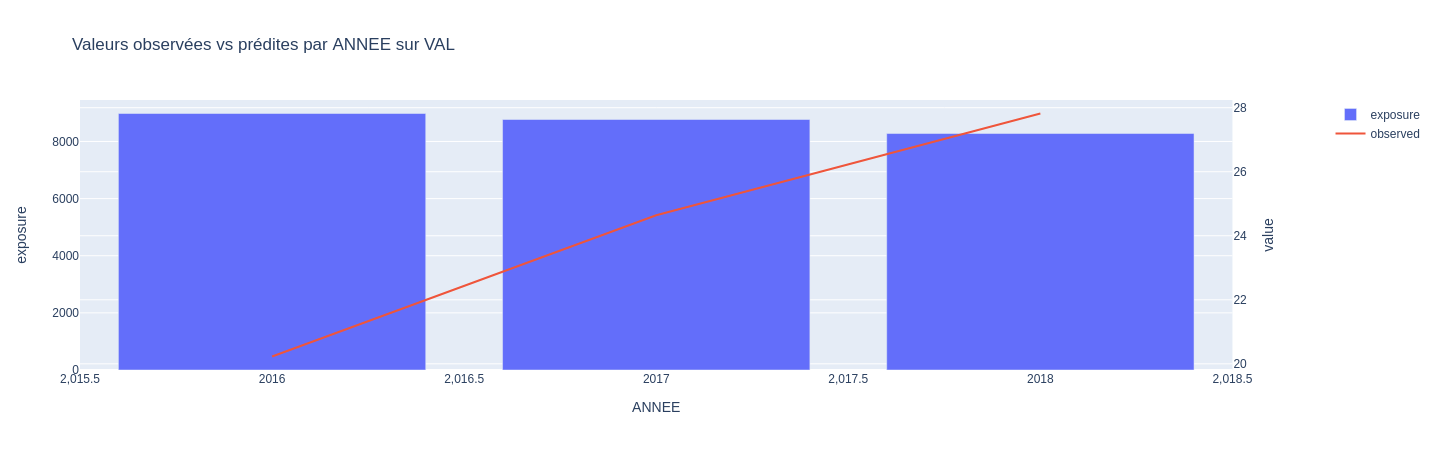

,ANNEE,EXPO,observed
0,2016,8979.487207,20.229198
1,2017,8769.163519,24.640705
2,2018,8278.281779,27.818941


In [26]:
plot_obs_pred_2(
    df=df_val,
    feature="ANNEE",
    weight="EXPO",
    observed="COUT",
    use_predicted=False,
    y_label="Pure Premium",
    title_train_test="VAL",
    output_df=True
)

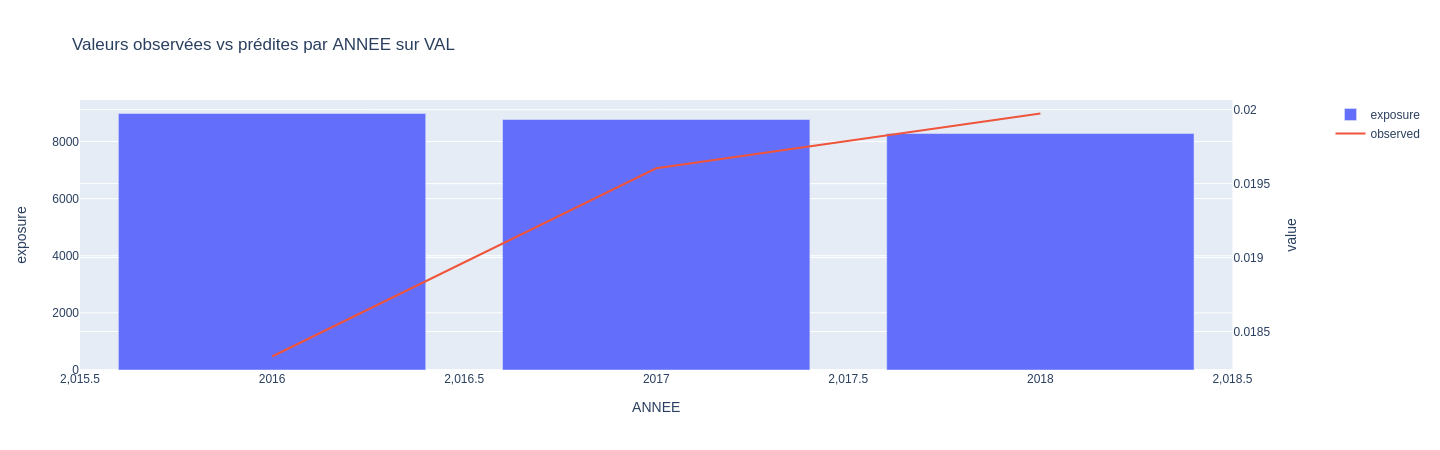

,ANNEE,EXPO,observed
0,2016,8979.487207,0.018331
1,2017,8769.163519,0.019604
2,2018,8278.281779,0.019974


In [27]:
plot_obs_pred_2(
    df=df_val,
    feature="ANNEE",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    y_label="Pure Premium",
    title_train_test="VAL",
    output_df=True
)

**INSIGHT** Il y a bien un effet d'inflation

- il faut redresser les données historiques avant analyse
- il faut anticiper un facteur d'inflation pour le futur

### Par variable

#### FORMULE

In [47]:
from hackathondsa_groupe4.viz.graphs import plot_obs_pred_3

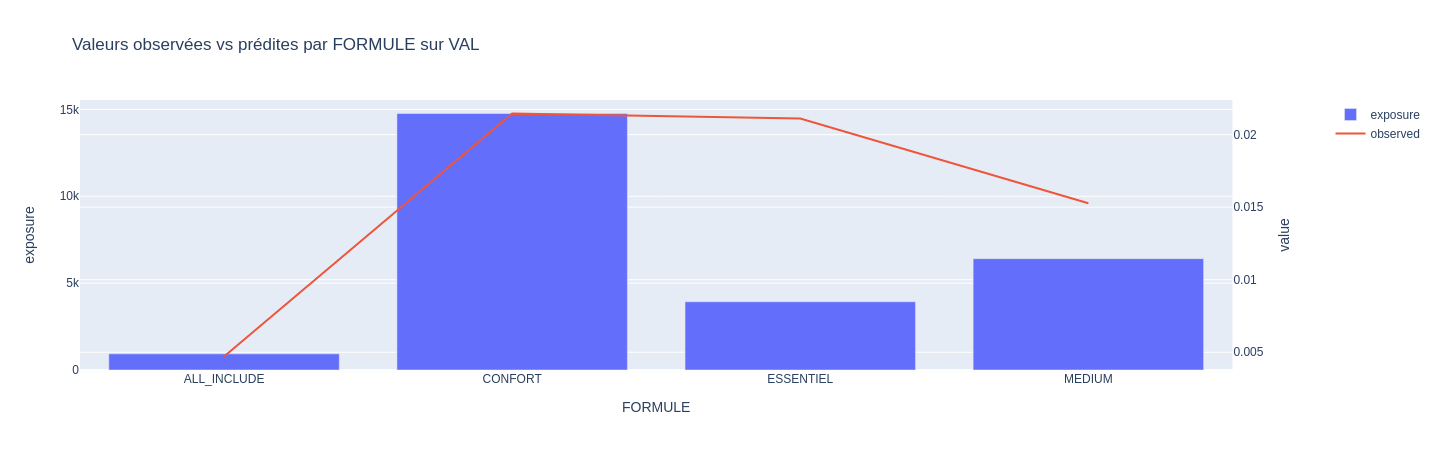

,FORMULE,EXPO,observed
0,ALL_INCLUDE,928.212298,0.004709
1,CONFORT,14764.709199,0.021456
2,ESSENTIEL,3927.093421,0.021108
3,MEDIUM,6406.917588,0.015266


In [38]:
plot_obs_pred_3(
    df=df_val,
    feature="FORMULE",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=False,
    year_field='ANNEE',
    y_label="Pure Premium",
    title_train_test="VAL",
    output_df=True
)

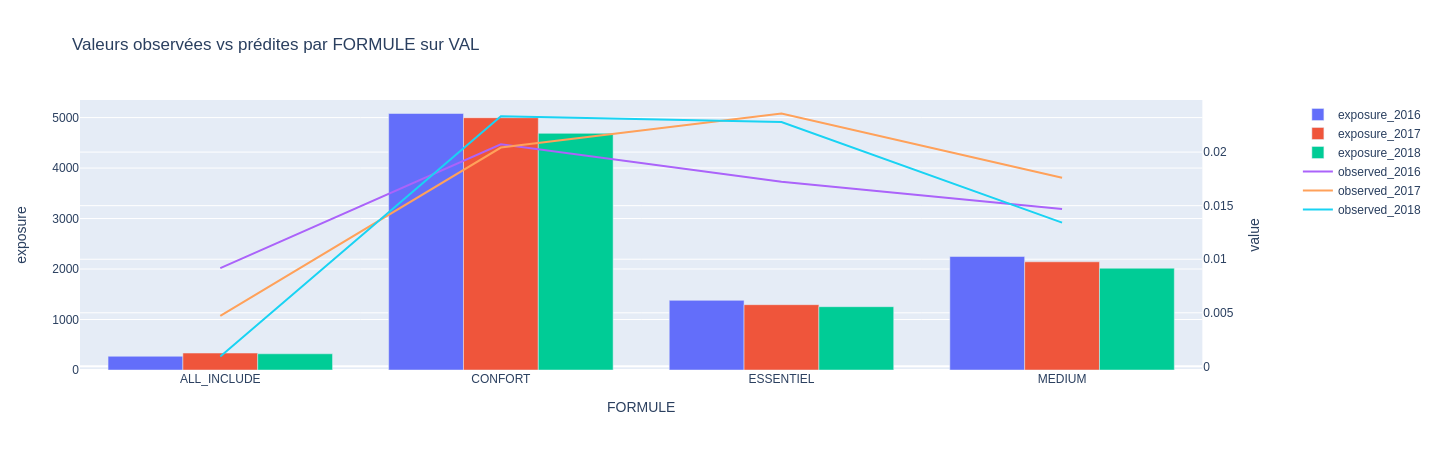

,FORMULE,ANNEE,EXPO,observed
0,ALL_INCLUDE,2016,271.668464,0.009167
1,ALL_INCLUDE,2017,335.478115,0.004724
2,ALL_INCLUDE,2018,321.065718,0.000922
3,CONFORT,2016,5080.709342,0.020729
4,CONFORT,2017,4996.887748,0.020426
5,CONFORT,2018,4687.112109,0.023344
6,ESSENTIEL,2016,1379.342412,0.017225
7,ESSENTIEL,2017,1293.846946,0.023603
8,ESSENTIEL,2018,1253.904063,0.022804
9,MEDIUM,2016,2247.766989,0.014698


In [53]:
plot_obs_pred_3(
    df=df_val,
    feature="FORMULE",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

**INSIGHT** : une différence `ALL_INCLUSIVE` vs reste qui semble stable dans le temps

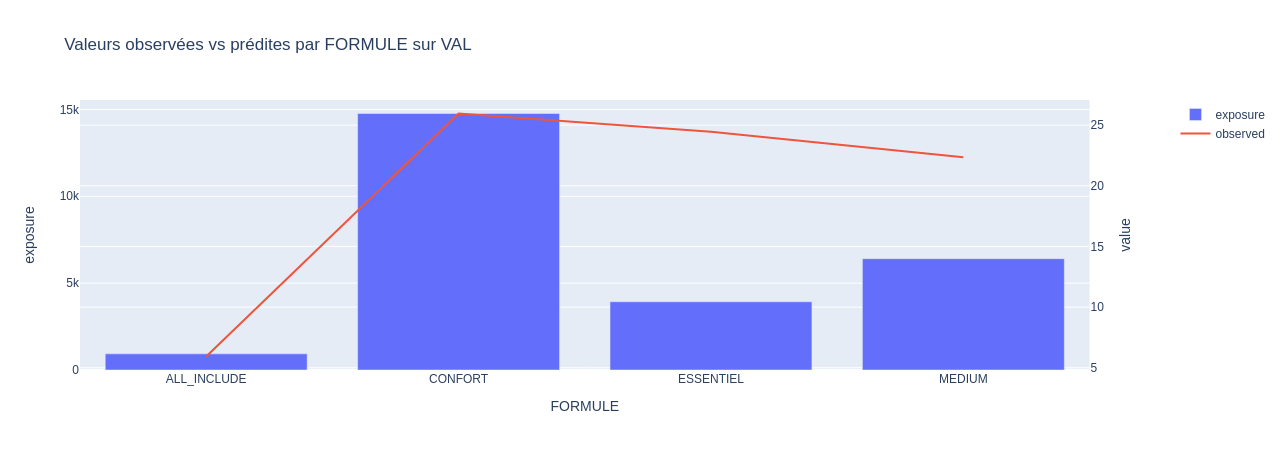

,FORMULE,EXPO,observed
0,ALL_INCLUDE,928.212298,5.927862
1,CONFORT,14764.709199,25.958086
2,ESSENTIEL,3927.093421,24.459342
3,MEDIUM,6406.917588,22.350719


In [86]:
plot_obs_pred_3(
    df=df_val,
    feature="FORMULE",
    weight="EXPO",
    observed="COUT",
    use_predicted=False,
    use_year=False,
    year_field='ANNEE',
    y_label="Pure Premium",
    title_train_test="VAL",
    output_df=True
)

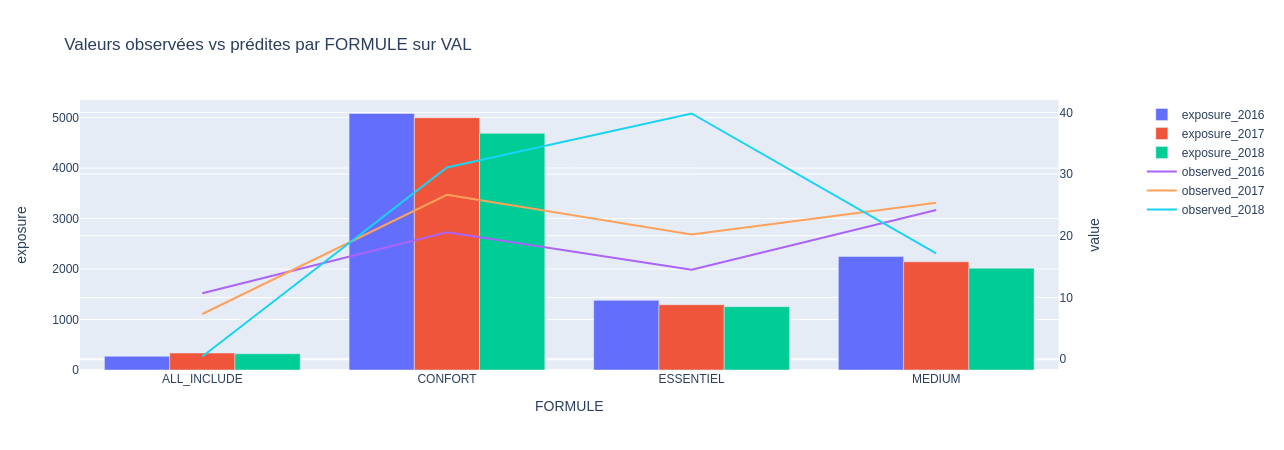

,FORMULE,ANNEE,EXPO,observed
0,ALL_INCLUDE,2016,271.668464,10.696635
1,ALL_INCLUDE,2017,335.478115,7.322562
2,ALL_INCLUDE,2018,321.065718,0.435478
3,CONFORT,2016,5080.709342,20.557188
4,CONFORT,2017,4996.887748,26.649626
5,CONFORT,2018,4687.112109,31.075276
6,ESSENTIEL,2016,1379.342412,14.484234
7,ESSENTIEL,2017,1293.846946,20.210640
8,ESSENTIEL,2018,1253.904063,39.816387
9,MEDIUM,2016,2247.766989,24.165348


In [87]:
plot_obs_pred_3(
    df=df_val,
    feature="FORMULE",
    weight="EXPO",
    observed="COUT",
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    y_label="Pure Premium",
    title_train_test="VAL",
    output_df=True
)

#### TYPE_RESIDENCE

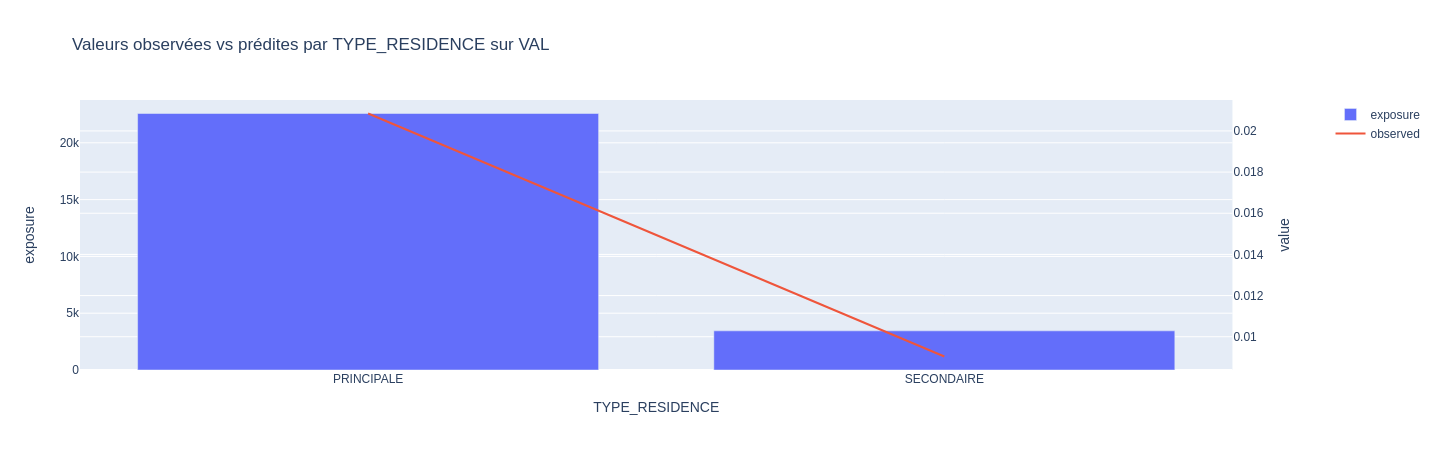

,TYPE_RESIDENCE,EXPO,observed
0,PRINCIPALE,22580.470690,0.020846
1,SECONDAIRE,3446.461815,0.009040


In [55]:
plot_obs_pred_3(
    df=df_val,
    feature="TYPE_RESIDENCE",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=False,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

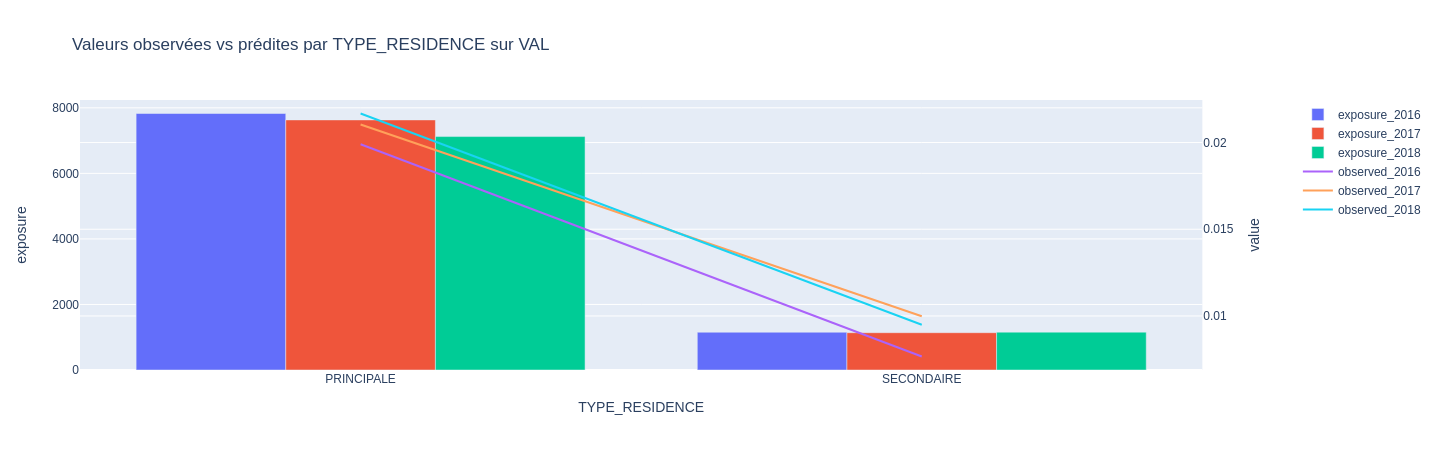

,TYPE_RESIDENCE,ANNEE,EXPO,observed
0,PRINCIPALE,2016,7826.835248,0.019903
1,PRINCIPALE,2017,7630.827544,0.021040
2,PRINCIPALE,2018,7122.807899,0.021675
3,SECONDAIRE,2016,1152.651959,0.007661
4,SECONDAIRE,2017,1138.335975,0.009980
5,SECONDAIRE,2018,1155.473880,0.009489


In [54]:
plot_obs_pred_3(
    df=df_val,
    feature="TYPE_RESIDENCE",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

**INSIGHT** : une différence `PRINCIPALE` vs reste qui semble stable dans le temps

#### TYPE_HABITATION

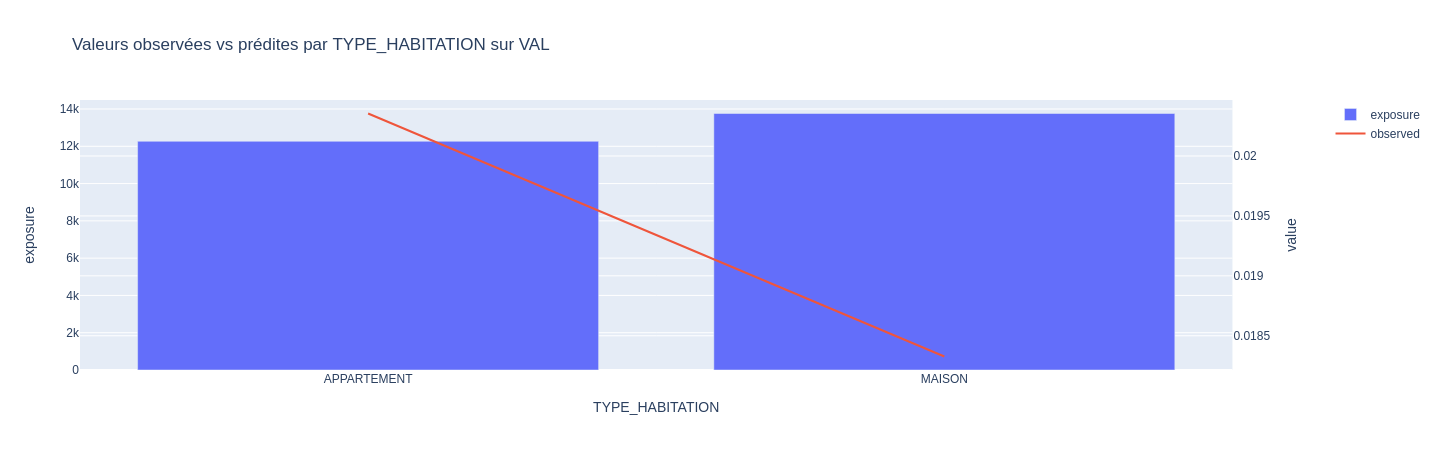

,TYPE_HABITATION,EXPO,observed
0,APPARTEMENT,12267.800277,0.020355
1,MAISON,13759.132228,0.018327


In [57]:
plot_obs_pred_3(
    df=df_val,
    feature="TYPE_HABITATION",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=False,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

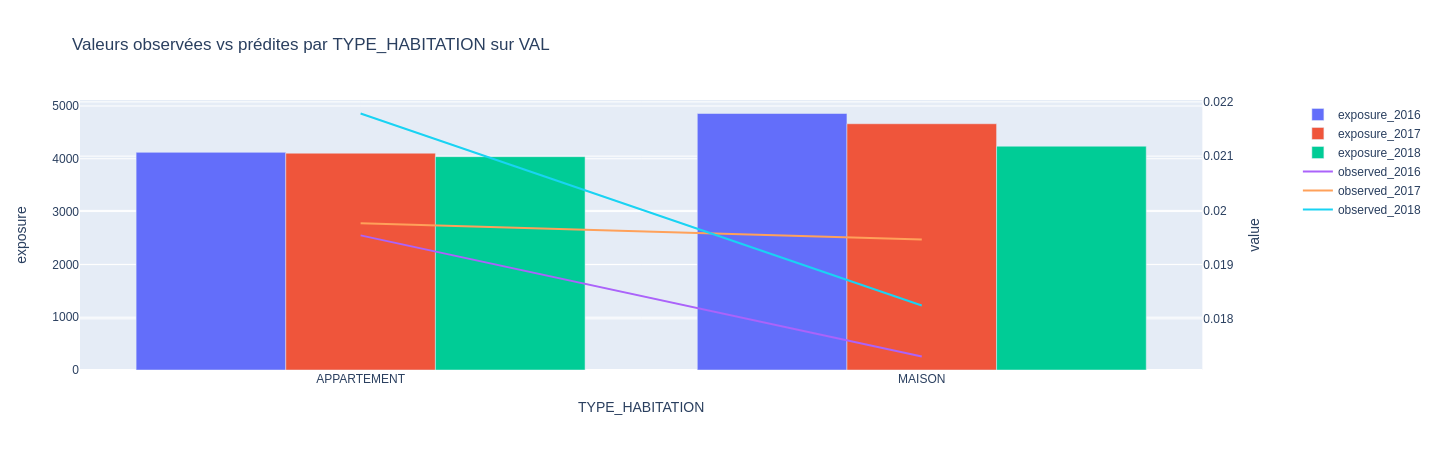

,TYPE_HABITATION,ANNEE,EXPO,observed
0,APPARTEMENT,2016,4121.909413,0.019539
1,APPARTEMENT,2017,4105.715685,0.019765
2,APPARTEMENT,2018,4040.175179,0.021786
3,MAISON,2016,4857.577794,0.017306
4,MAISON,2017,4663.447834,0.019462
5,MAISON,2018,4238.106600,0.018247


In [58]:
plot_obs_pred_3(
    df=df_val,
    feature="TYPE_HABITATION",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

#### NB_PIECES

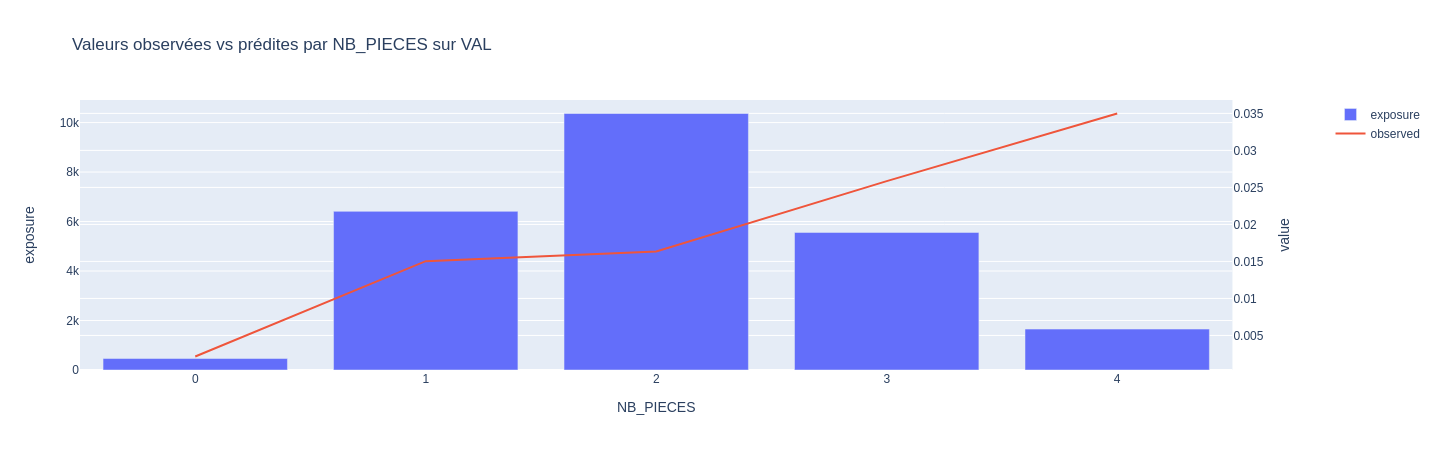

,NB_PIECES,EXPO,observed
0,0.0,463.657350,0.002157
1,1.0,6411.428195,0.015035
2,2.0,10367.070942,0.016351
3,3.0,5560.981853,0.025845
4,4.0,1653.643028,0.034984


In [60]:
plot_obs_pred_3(
    df=df_val,
    feature="NB_PIECES",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=False,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

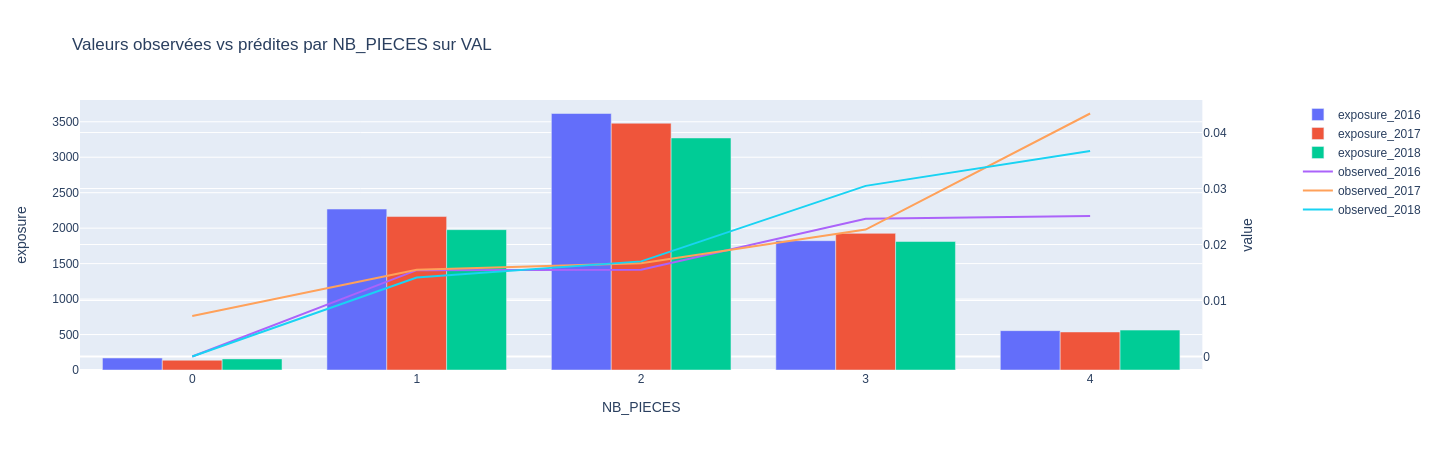

,NB_PIECES,ANNEE,EXPO,observed
0,0.0,2016,168.934225,0.000000
1,0.0,2017,138.046431,0.007244
2,0.0,2018,156.676694,0.000000
3,1.0,2016,2269.186152,0.015426
4,1.0,2017,2163.562716,0.015477
5,1.0,2018,1978.679328,0.014104
6,2.0,2016,3616.517633,0.015481
7,2.0,2017,3478.926070,0.016654
8,2.0,2018,3271.627238,0.016990
9,3.0,2016,1822.999928,0.024587


In [61]:
plot_obs_pred_3(
    df=df_val,
    feature="NB_PIECES",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

**INSIGHT** : une différence `0` vs `1-2` vs `3` vs `4` stable

#### SITUATION_JURIDIQUE

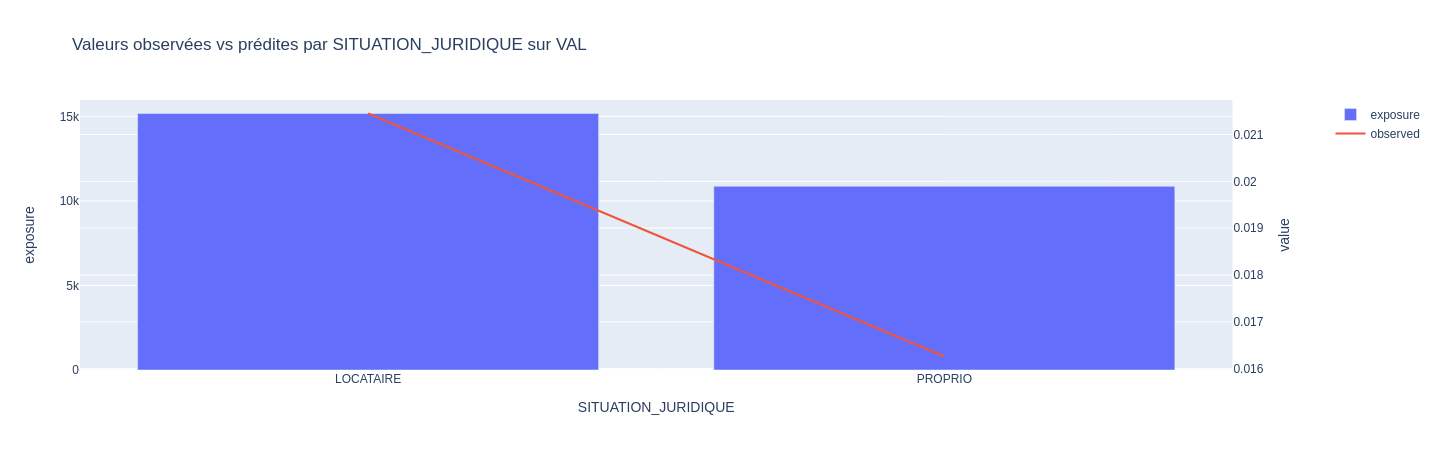

,SITUATION_JURIDIQUE,EXPO,observed
0,LOCATAIRE,15165.783265,0.021447
1,PROPRIO,10861.149240,0.016260


In [62]:
plot_obs_pred_3(
    df=df_val,
    feature="SITUATION_JURIDIQUE",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=False,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

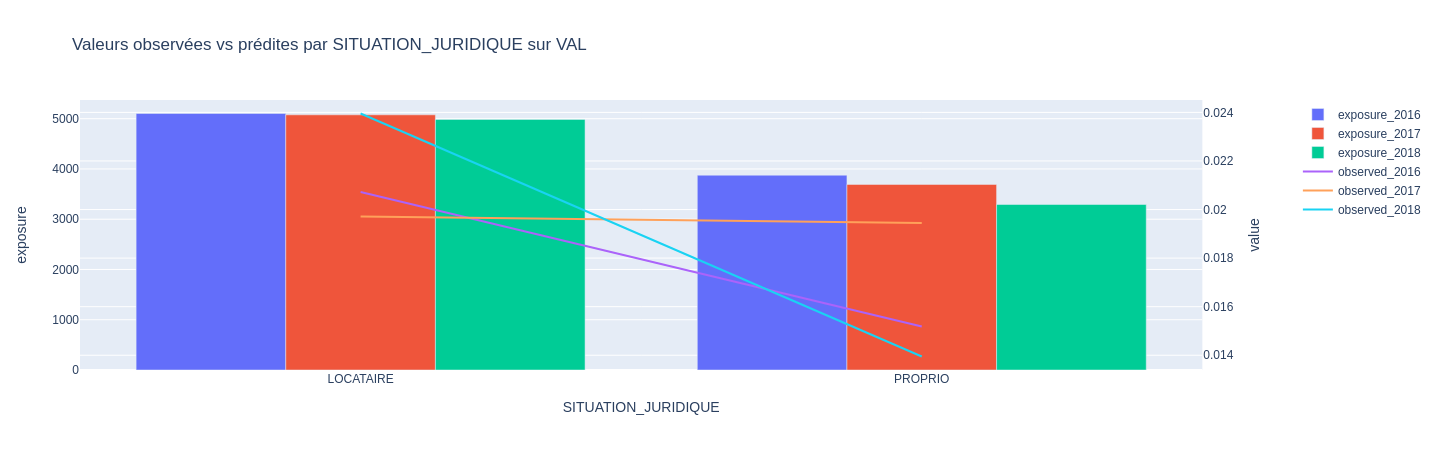

,SITUATION_JURIDIQUE,ANNEE,EXPO,observed
0,LOCATAIRE,2016,5103.451869,0.020720
1,LOCATAIRE,2017,5076.909661,0.019716
2,LOCATAIRE,2018,4985.421735,0.023954
3,PROPRIO,2016,3876.035338,0.015186
4,PROPRIO,2017,3692.253858,0.019449
5,PROPRIO,2018,3292.860044,0.013949


In [63]:
plot_obs_pred_3(
    df=df_val,
    feature="SITUATION_JURIDIQUE",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

**INSIGHT** : une différence `LOCATAIRE` vs `PROPRIETAIRE`  stable

#### NIVEAU_JURIDIQUE

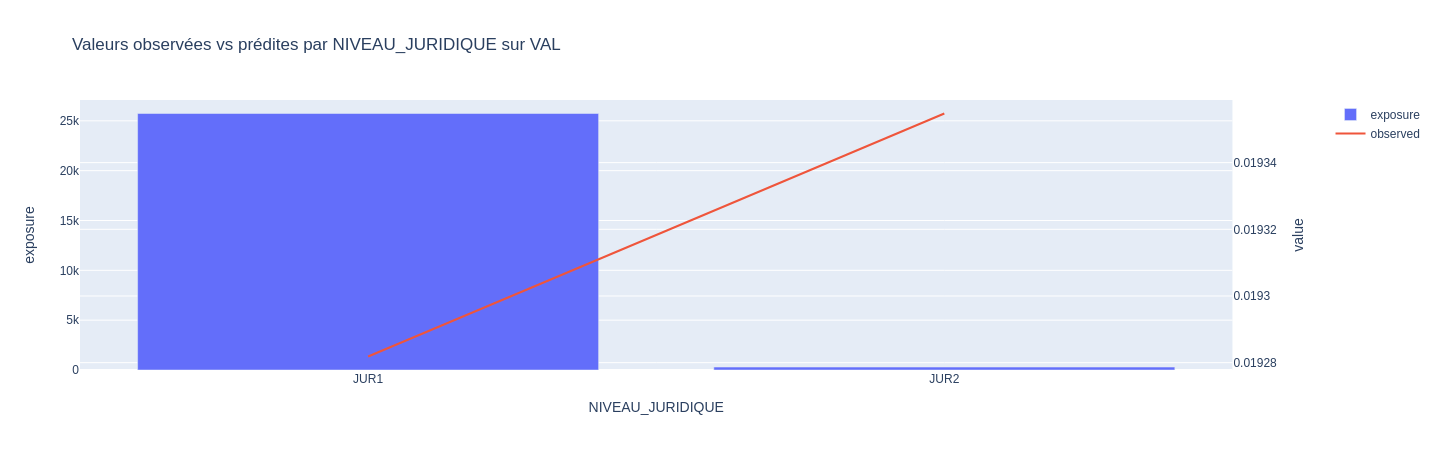

,NIVEAU_JURIDIQUE,EXPO,observed
0,JUR1,25735.191306,0.019282
1,JUR2,291.741199,0.019355


In [64]:
plot_obs_pred_3(
    df=df_val,
    feature="NIVEAU_JURIDIQUE",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=False,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

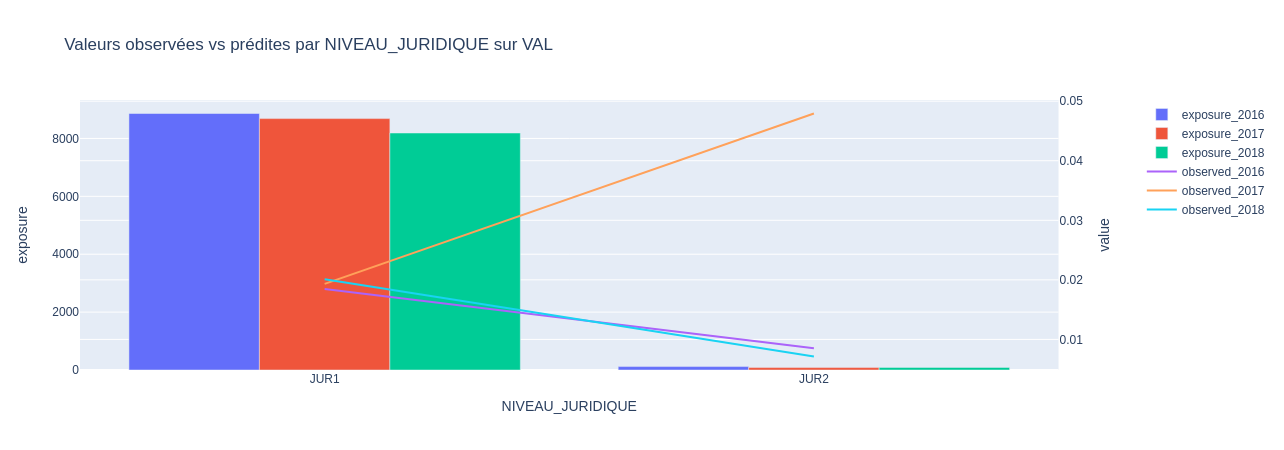

,NIVEAU_JURIDIQUE,ANNEE,EXPO,observed
0,JUR1,2016,8861.846119,0.018462
1,JUR1,2017,8685.709974,0.019332
2,JUR1,2018,8187.635212,0.020117
3,JUR2,2016,117.641088,0.008500
4,JUR2,2017,83.453545,0.047931
5,JUR2,2018,90.646566,0.007133


In [65]:
plot_obs_pred_3(
    df=df_val,
    feature="NIVEAU_JURIDIQUE",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

**INSIGHT** : A ABANDONNER NON STABLE

#### VALEUR_DES_BIENS

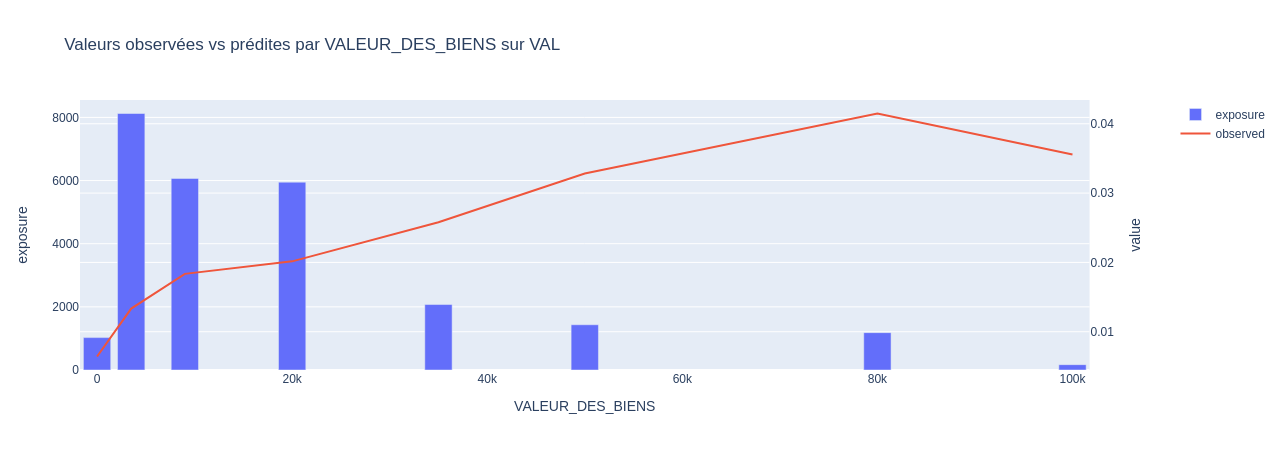

,VALEUR_DES_BIENS,EXPO,observed
0,0.0,1026.207727,0.006429
1,3500.0,8124.009575,0.013344
2,9000.0,6068.146915,0.018350
3,20000.0,5949.864318,0.020155
4,35000.0,2073.816003,0.025788
5,50000.0,1433.003950,0.032827
6,80000.0,1183.155419,0.041479
7,100000.0,168.728599,0.035560


In [66]:
plot_obs_pred_3(
    df=df_val,
    feature="VALEUR_DES_BIENS",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=False,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

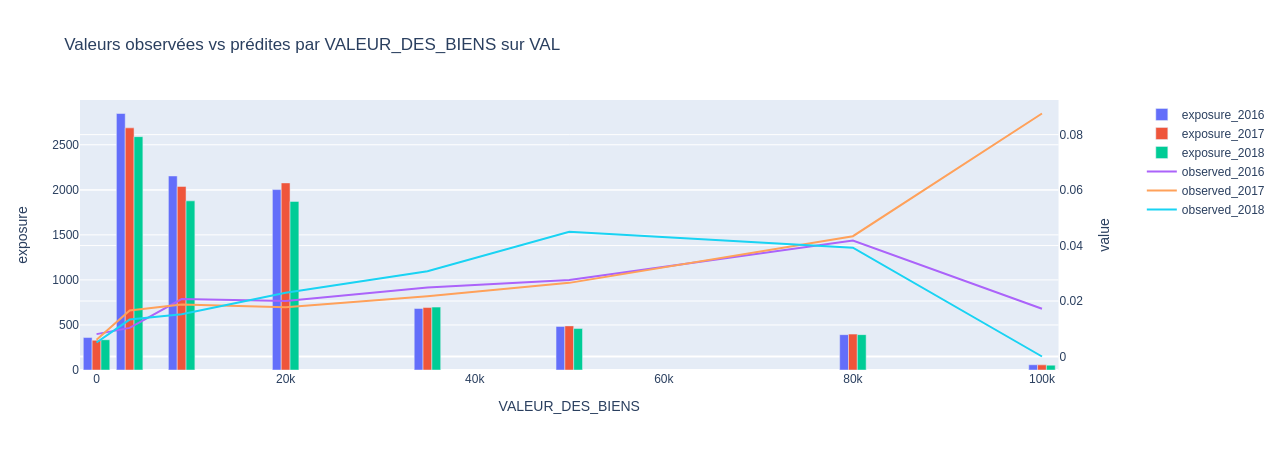

,VALEUR_DES_BIENS,ANNEE,EXPO,observed
0,0.0,2016,360.271188,0.008069
1,0.0,2017,330.139312,0.006058
2,0.0,2018,335.797227,0.005034
3,3500.0,2016,2846.802543,0.010323
4,3500.0,2017,2687.305835,0.016567
5,3500.0,2018,2589.901197,0.013319
6,9000.0,2016,2153.621819,0.020707
7,9000.0,2017,2037.278604,0.018760
8,9000.0,2018,1877.246492,0.015202
9,20000.0,2016,2002.169788,0.019985


In [67]:
plot_obs_pred_3(
    df=df_val,
    feature="VALEUR_DES_BIENS",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

**INSIGHT** : il y a bien un impact croissant (surpenant) en NB an vfonction de la valeur des biens (ordinal)

**=>** Ordinal encoding

#### OBJETS_DE_VALEUR

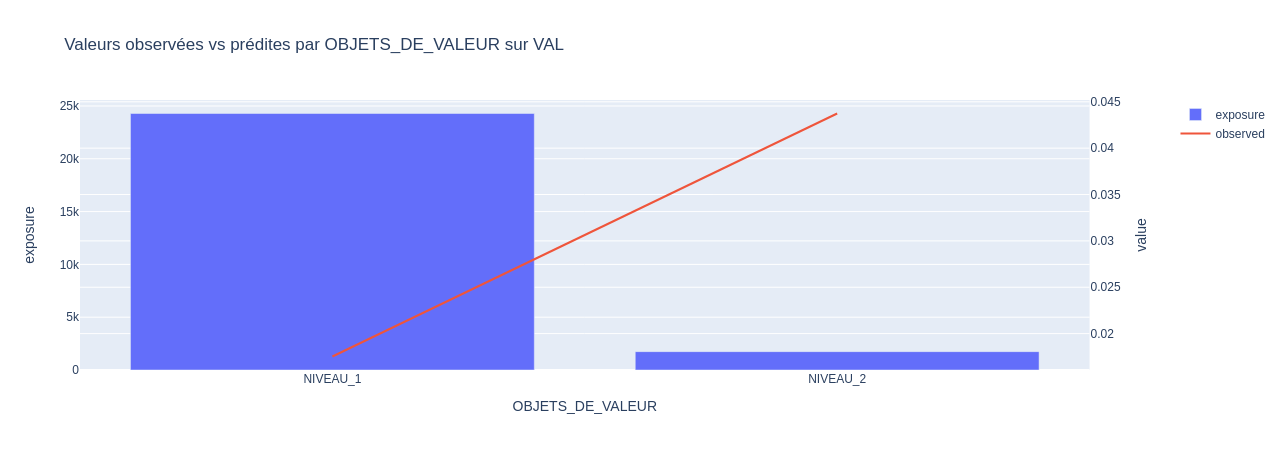

,OBJETS_DE_VALEUR,EXPO,observed
0,NIVEAU_1,24287.749770,0.017532
1,NIVEAU_2,1739.182735,0.043737


In [68]:
plot_obs_pred_3(
    df=df_val,
    feature="OBJETS_DE_VALEUR",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=False,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

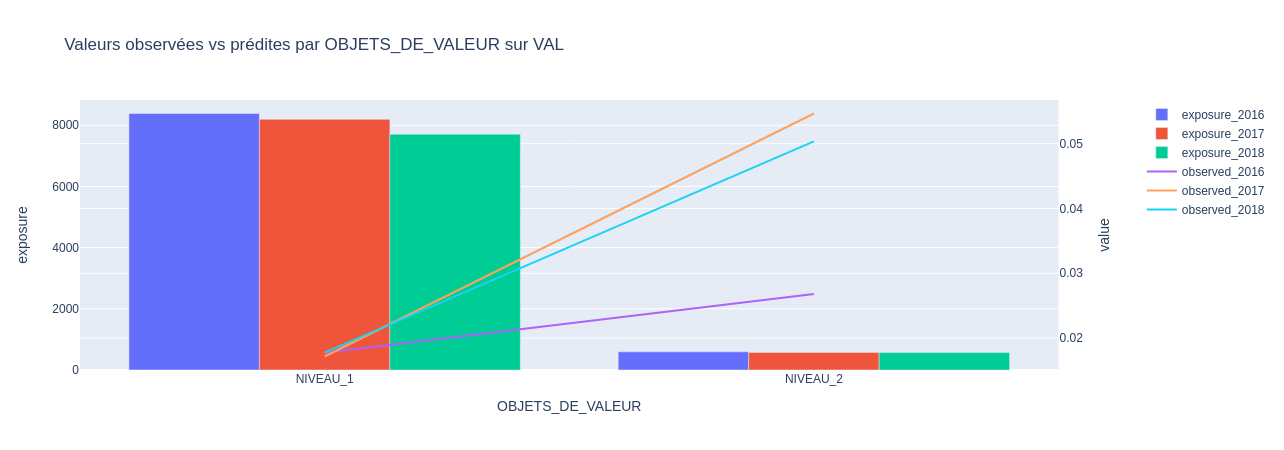

,OBJETS_DE_VALEUR,ANNEE,EXPO,observed
0,NIVEAU_1,2016,8385.437913,0.017731
1,NIVEAU_1,2017,8193.884851,0.017142
2,NIVEAU_1,2018,7708.427006,0.017728
3,NIVEAU_2,2016,594.049294,0.026800
4,NIVEAU_2,2017,575.278668,0.054671
5,NIVEAU_2,2018,569.854773,0.050356


In [69]:
plot_obs_pred_3(
    df=df_val,
    feature="OBJETS_DE_VALEUR",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

**INSIGHT** : il y a bien un effet

#### ZONIER

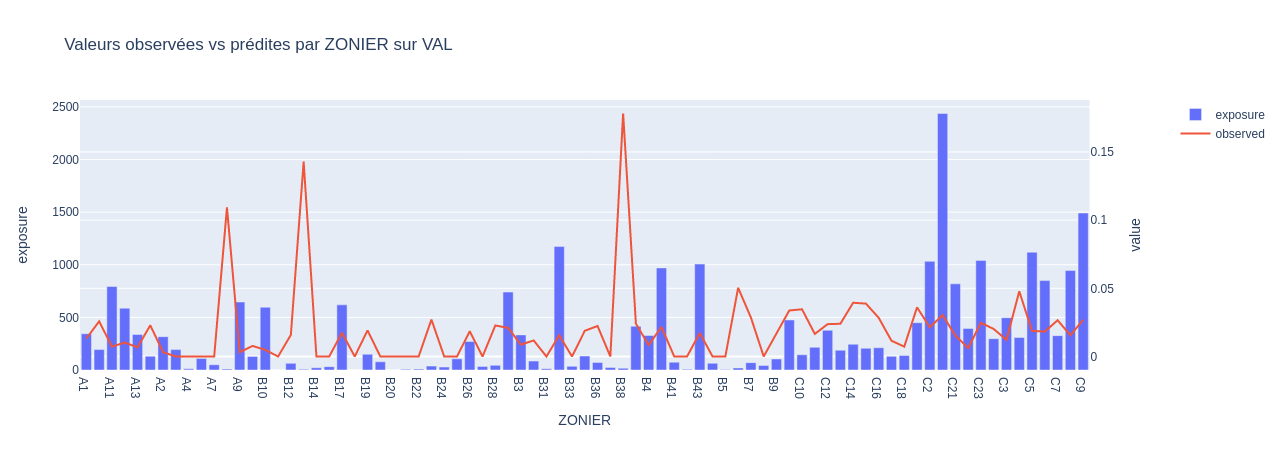

,ZONIER,EXPO,observed
0,A1,344.411467,0.013213
1,A10,194.005524,0.025772
2,A11,793.290423,0.007246
3,A12,587.430674,0.010214
4,A13,337.455798,0.006744
...,...,...,...
74,C5,1119.508477,0.018754
75,C6,849.604234,0.018281
76,C7,326.478680,0.026598
77,C8,944.972472,0.015563


In [70]:
plot_obs_pred_3(
    df=df_val,
    feature="ZONIER",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=False,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

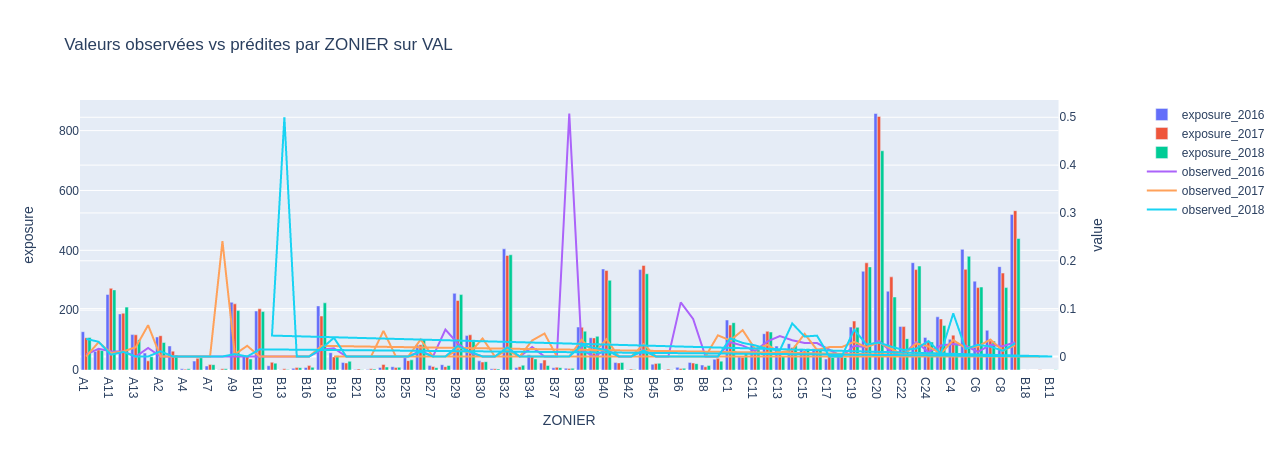

,ZONIER,ANNEE,EXPO,observed
0,A1,2016,128.005475,0.004302
1,A1,2017,107.808738,0.000000
2,A1,2018,108.597254,0.036833
3,A10,2016,62.095888,0.016104
4,A10,2017,66.980872,0.029859
...,...,...,...,...
226,C8,2017,324.027305,0.012294
227,C8,2018,275.468474,0.011925
228,C9,2016,519.786270,0.029870
229,C9,2017,532.590139,0.023439


In [71]:
plot_obs_pred_3(
    df=df_val,
    feature="ZONIER",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

**INSIGHT** : N'a pas l'air stable, on a surtout de l'exposition en C

#### NBSIN_TYPE1_AN1

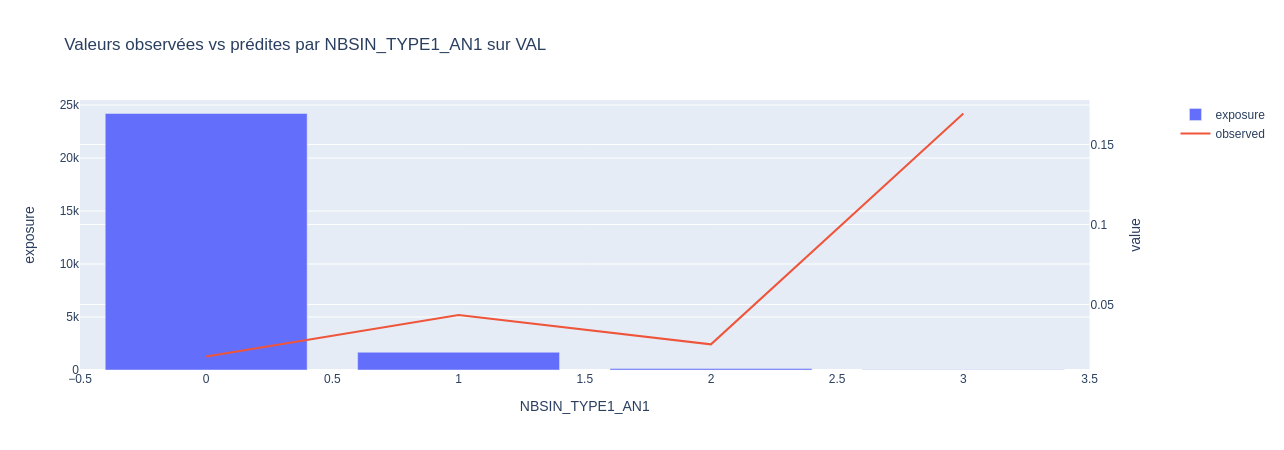

,NBSIN_TYPE1_AN1,EXPO,observed
0,0,24199.654196,0.017508
1,1,1675.291243,0.043376
2,2,140.180599,0.025104
3,3,11.806467,0.169399


In [76]:
plot_obs_pred_3(
    df=df_val,
    feature="NBSIN_TYPE1_AN1",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=False,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

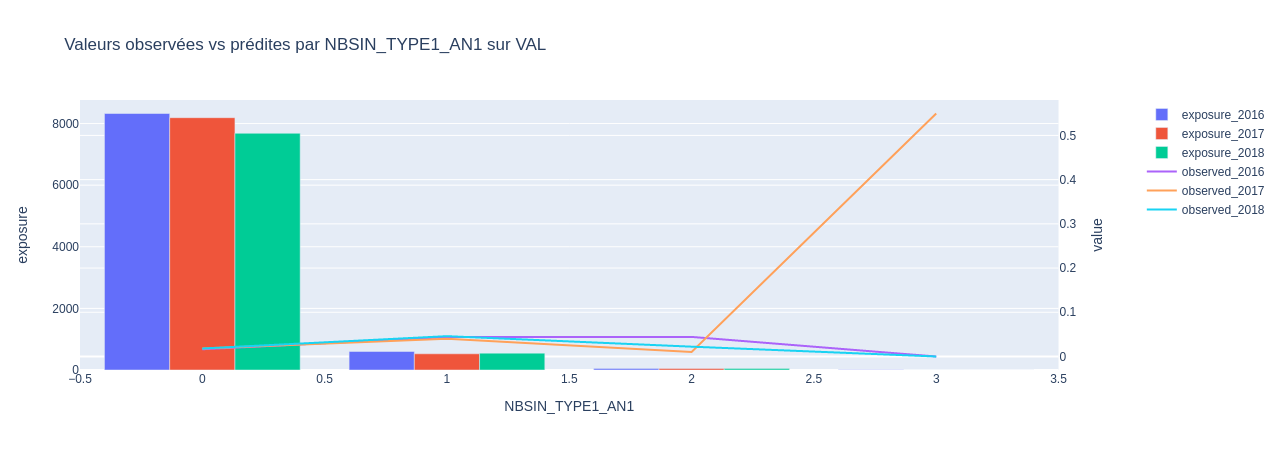

,NBSIN_TYPE1_AN1,ANNEE,EXPO,observed
0,0,2016,8326.199555,0.016360
1,0,2017,8189.767362,0.018108
2,0,2018,7683.687279,0.018112
3,1,2016,601.975326,0.043842
4,1,2017,525.677580,0.040120
5,1,2018,547.638338,0.045991
6,2,2016,45.145203,0.044301
7,2,2017,50.079234,0.010366
8,2,2018,44.956162,0.022244
9,3,2016,6.167123,0.000000


In [77]:
plot_obs_pred_3(
    df=df_val,
    feature="NBSIN_TYPE1_AN1",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

**INSIGHT** : Puet être un petit effet `0` vs `1+`

#### NBSIN_TYPE1_AN3

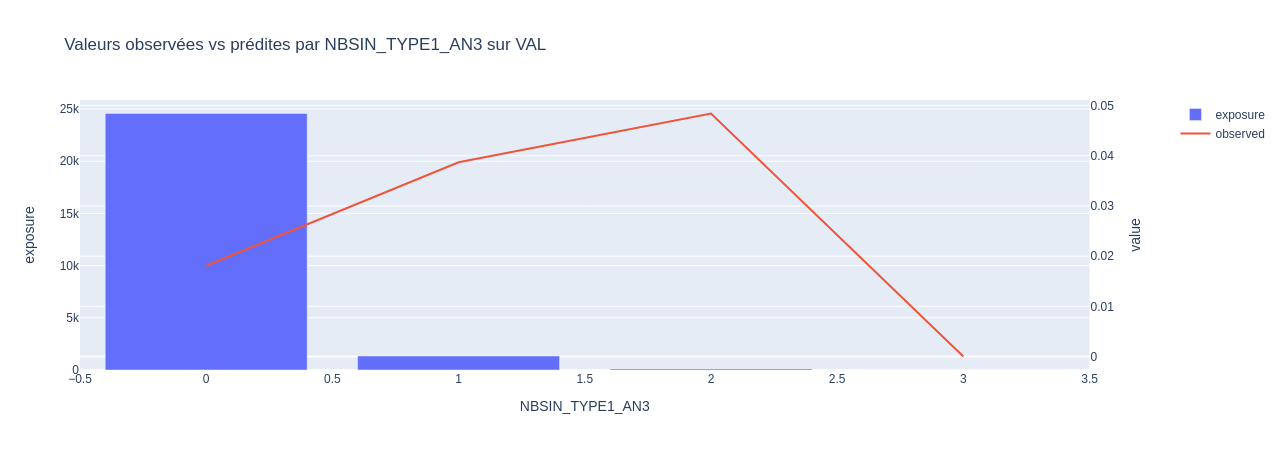

,NBSIN_TYPE1_AN3,EXPO,observed
0,0,24573.579674,0.018101
1,1,1339.782186,0.038708
2,2,107.447357,0.048440
3,3,6.123288,0.000000


In [78]:
plot_obs_pred_3(
    df=df_val,
    feature="NBSIN_TYPE1_AN3",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=False,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

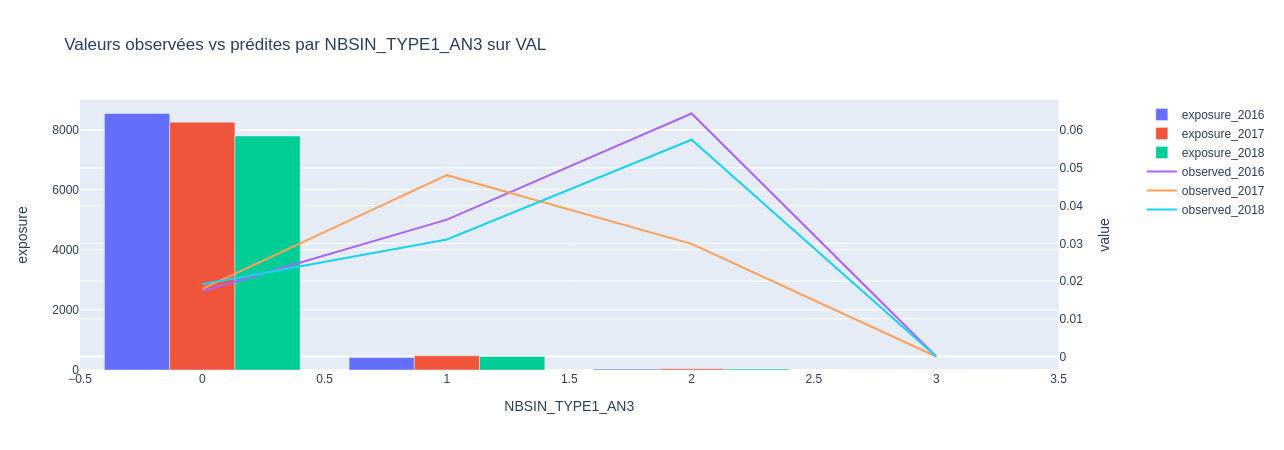

,NBSIN_TYPE1_AN3,ANNEE,EXPO,observed
0,0,2016,8536.046121,0.017300
1,0,2017,8248.958612,0.017914
2,0,2018,7788.574941,0.019176
3,1,2016,413.383553,0.036286
4,1,2017,475.491793,0.048078
5,1,2018,450.906839,0.031049
6,2,2016,29.934245,0.064433
7,2,2017,42.713113,0.029873
8,2,2018,34.799999,0.057471
9,3,2016,0.123288,0.000000


In [79]:
plot_obs_pred_3(
    df=df_val,
    feature="NBSIN_TYPE1_AN3",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

**INSIGHT** : Puet être un petit effet `0` vs `1+`

#### NBSIN_TYPE2_AN1

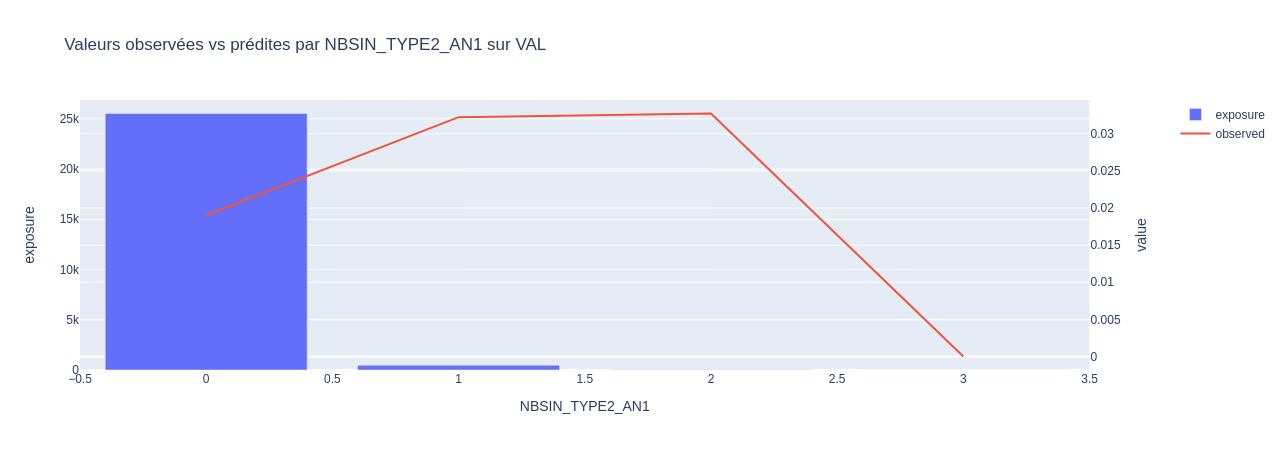

,NBSIN_TYPE2_AN1,EXPO,observed
0,0,25528.226114,0.019031
1,1,466.162841,0.032251
2,2,30.543551,0.032740
3,3,2.000000,0.000000


In [80]:
plot_obs_pred_3(
    df=df_val,
    feature="NBSIN_TYPE2_AN1",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=False,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

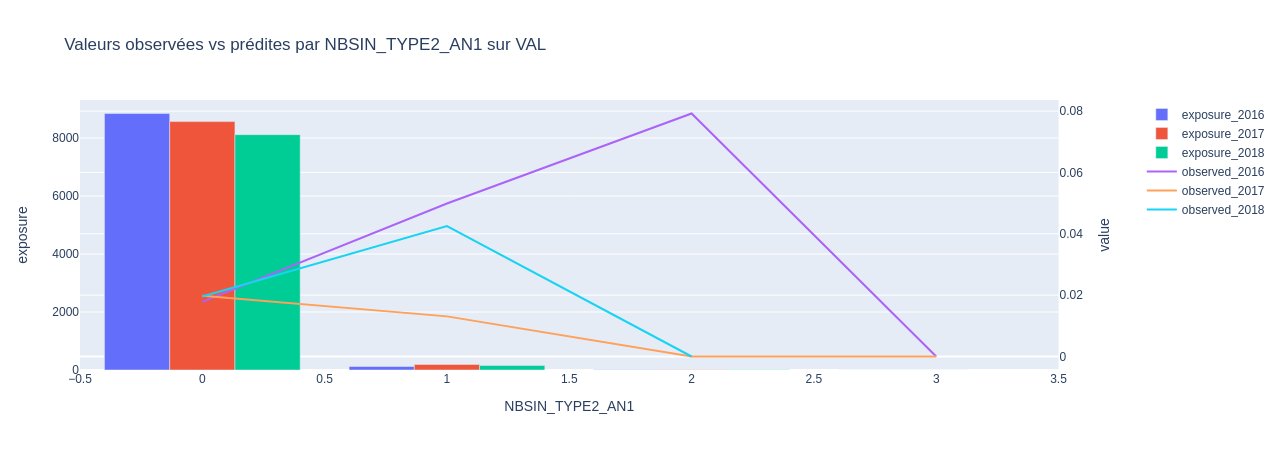

,NBSIN_TYPE2_AN1,ANNEE,EXPO,observed
0,0,2016,8845.572142,0.017817
1,0,2017,8567.002324,0.019772
2,0,2018,8115.651647,0.019572
3,1,2016,120.290408,0.049879
4,1,2017,192.557370,0.013082
5,1,2018,153.315063,0.042495
6,2,2016,12.624657,0.079210
7,2,2017,8.603825,0.000000
8,2,2018,9.315068,0.000000
9,3,2016,1.000000,0.000000


In [81]:
plot_obs_pred_3(
    df=df_val,
    feature="NBSIN_TYPE2_AN1",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

**INSIGHT** : PAS STABLE A EXCLURE

#### NBSIN_TYPE2_AN2

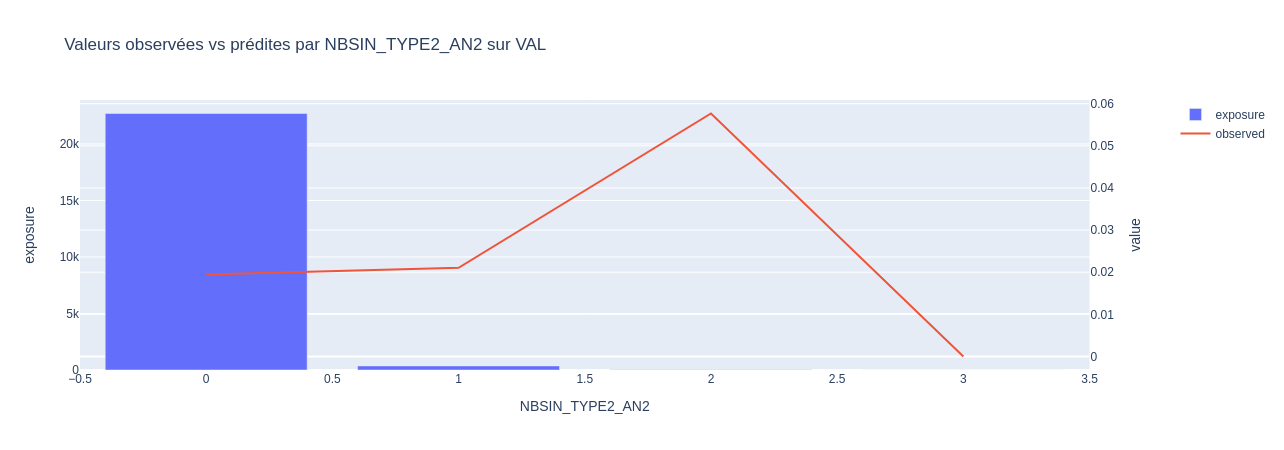

,NBSIN_TYPE2_AN2,EXPO,observed
0,0.0,22689.858124,0.019442
1,1.0,358.047628,0.021035
2,2.0,17.341215,0.057666
3,3.0,1.000000,0.000000


In [82]:
plot_obs_pred_3(
    df=df_val,
    feature="NBSIN_TYPE2_AN2",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=False,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

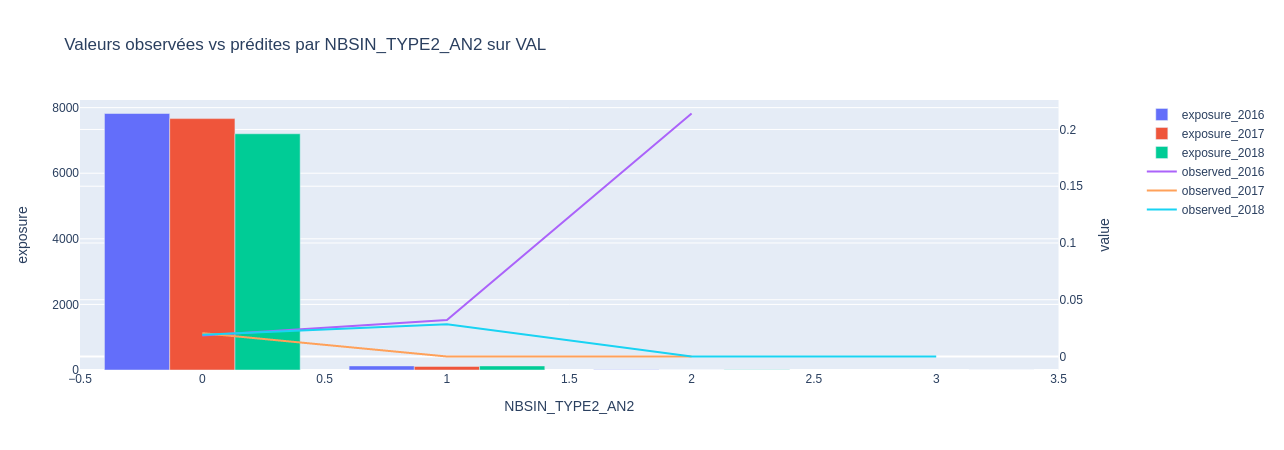

,NBSIN_TYPE2_AN2,ANNEE,EXPO,observed
0,0.0,2016,7821.295484,0.018562
1,0.0,2017,7665.373957,0.020587
2,0.0,2018,7203.188683,0.019178
3,1.0,2016,124.345202,0.032169
4,1.0,2017,109.612019,0.000000
5,1.0,2018,124.090407,0.028459
6,2.0,2016,4.671232,0.214076
7,2.0,2017,1.456284,0.000000
8,2.0,2018,11.213698,0.000000
9,3.0,2018,1.000000,0.000000


In [83]:
plot_obs_pred_3(
    df=df_val,
    feature="NBSIN_TYPE2_AN2",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

**INSIGHT** : PAS STABLE A EXCLURE

#### NBSIN_TYPE2_AN3

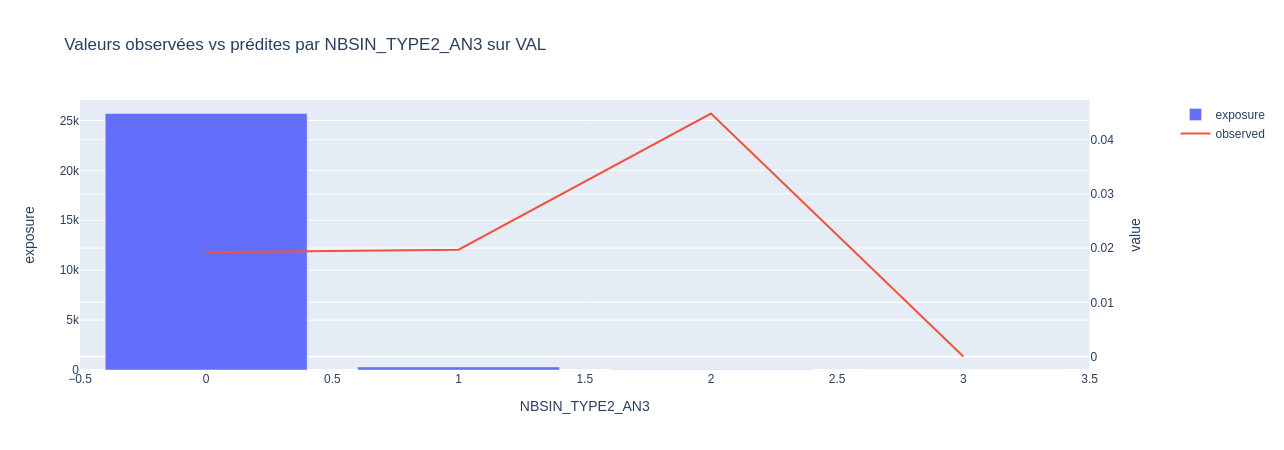

,NBSIN_TYPE2_AN3,EXPO,observed
0,0,25699.945447,0.019256
1,1,304.324045,0.019716
2,2,22.295890,0.044851
3,3,0.367123,0.000000


In [84]:
plot_obs_pred_3(
    df=df_val,
    feature="NBSIN_TYPE2_AN3",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=False,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

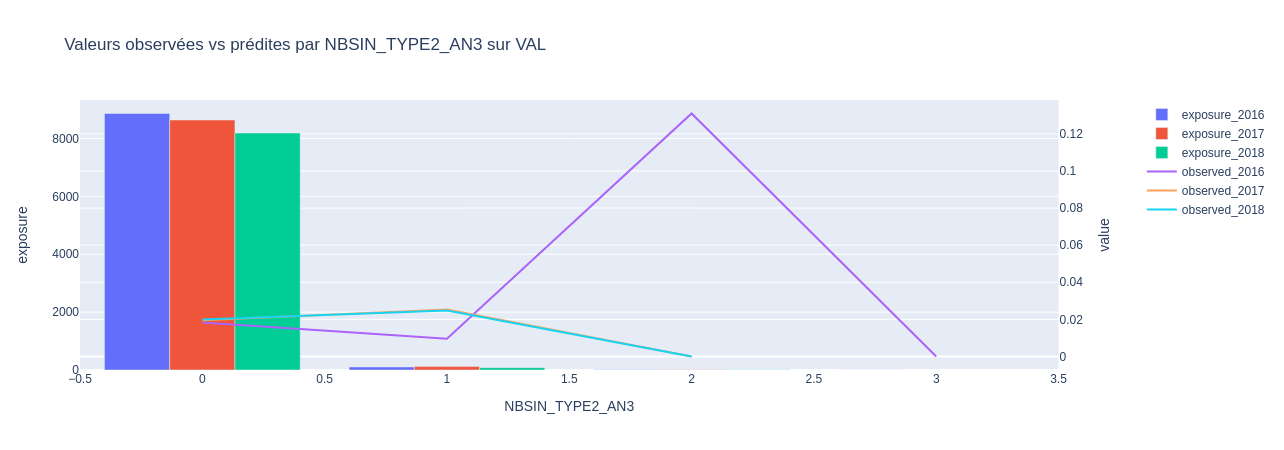

,NBSIN_TYPE2_AN3,ANNEE,EXPO,observed
0,0,2016,8866.651593,0.018339
1,0,2017,8641.442209,0.019546
2,0,2018,8191.851645,0.019941
3,1,2016,104.832875,0.009539
4,1,2017,118.721310,0.025269
5,1,2018,80.769860,0.024762
6,2,2016,7.635616,0.130965
7,2,2017,9.000000,0.000000
8,2,2018,5.660274,0.000000
9,3,2016,0.367123,0.000000


In [85]:
plot_obs_pred_3(
    df=df_val,
    feature="NBSIN_TYPE2_AN3",
    weight="EXPO",
    observed="NB",
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test="VAL",
    output_df=True
)

**INSIGHT** : PAS STABLE A EXCLURE